In [1]:
import sys
import os
import time
import numpy as np
import tensorflow as tf
import gpflow
import soundfile
import pickle
sys.path.append('../../../../')
import gpitch
from gpitch.amtgp import logistic
from gpitch import myplots
import soundfile
import sounddevice
import peakutils
from scipy import signal

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
active_device = sys.argv[1]  # configure gpu usage and plotting
gpitch.amtgp.init_settings(visible_device = active_device, interactive=True)

In [4]:
dirloc = '../../../../../datasets/maps/sample_rate_16khz/'
pattern = '*F*.wav'
bounds = [21, 109]
midi = np.asarray([str(i) for i in range(bounds[0], bounds[1])]).reshape(-1,)
filel = gpitch.amtgp.load_filenames(directory=dirloc, pattern=pattern, bounds=bounds)
Np = filel.size  # number of pitches to analyze

In [5]:
fs = 16e3  # sample frequency
N = 16000  # number of data points to load
x = np.linspace(0, (N-1.)/fs, N).reshape(-1, 1)  # time vector
Nc = 10  #  number of harmonics for component kernels

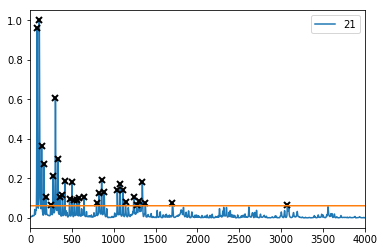

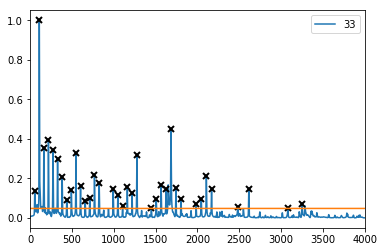

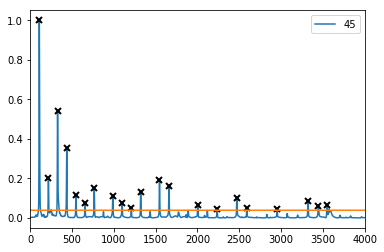

In [6]:
plt.figure(1, figsize=(16, 80))  
plt.figure(2, figsize=(16, 80))
nrow, ncol = 45, 2
for i in range(0, Np/3, 12):
#for i in range(0, Np):
    #print filel[i]
    y, fs = gpitch.amtgp.wavread(dirloc + filel[i], start=5000, N=N)  # load data
#     plt.figure(1)
#     plt.subplot(nrow, ncol, i+1)
#     plt.plot(x, y)
#     plt.legend([midi[i]])
         
    ideal_f0 = gpitch.amtgp.midi2frec(int(midi[i]))
    F_star, S_star, F, Y, S = gpitch.amtgp.init_com_params(y=y, fs=fs, Nh=Nc, 
                                                           ideal_f0=ideal_f0, scaled=True)
    win_size = 10
    win =  signal.hann(win_size)
    S = signal.convolve(S, win, mode='same') / sum(win)
    
    thres = 0.003/max(S)
    min_dist = 0.8*np.argmin(np.abs(F - ideal_f0))
    idx = peakutils.indexes(S, thres=thres, min_dist=min_dist)
    F_star, S_star = F[idx], S[idx]
    var_scale = S_star.sum()
    S_star /= 4.*var_scale 
    
#     plt.figure(2)
#     plt.subplot(nrow, ncol, i+1)
    plt.figure()
    plt.plot(F, S/ np.max(S))
    plt.plot(F_star, S_star/np.max(S_star), 'xk', mew=2)
    plt.plot(F, 0.*S + thres)
    plt.legend([midi[i]])
    #plt.xlim([0, 1.1*np.max(F_star)])
    plt.xlim([0, 4000])
    
    #sounddevice.play(y, fs)
    #time.sleep(1.0)

21
20


(0, 4000)

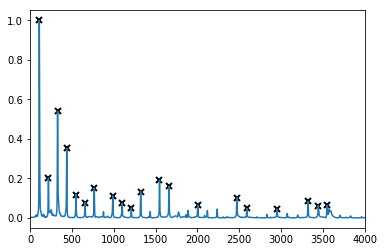

In [41]:
aux1 = np.flip(np.sort(S_star), 0)
aux2 = np.flip(np.argsort(S_star), 0)
maxh = 20
print aux1.size
if aux1.size > maxh :
    vvec = aux1[0:maxh]
    idxf = aux2[0:maxh]
else :
    vvec = aux1
    idxf = aux2
print vvec.size  
plt.figure()
plt.plot(F_star[idxf], vvec/ np.max(vvec), 'xk', mew=2)
plt.plot(F, S/ np.max(S))
plt.xlim([0, 4000])

In [8]:
tf.reset_default_graph()